In [1]:
import numpy as np
import scipy
import pandas as pd
import requests
from os import makedirs, path, listdir, remove
from bs4 import BeautifulSoup, SoupStrainer
import zipfile as zpf
from shutil import rmtree
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize
from matplotlib import cm

import httplib2
import geopandas as gpd
from tqdm import tqdm

(33, 10)


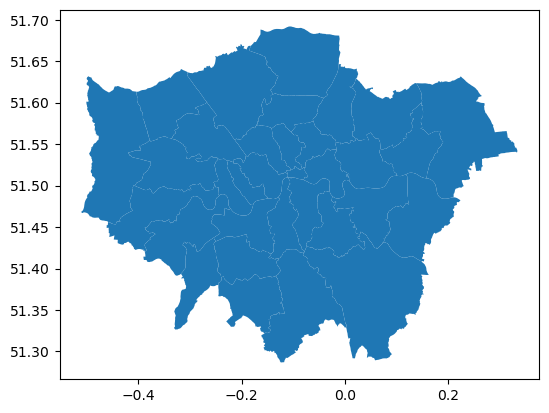

In [2]:
# Load map file
folder='tmp'
london_boroughs_gdf = gpd.read_file(path.join(folder, "london_boroughs_coordinates.shp"))
london_gdf = london_boroughs_gdf.dissolve()
print(london_boroughs_gdf.shape)
london_boroughs_gdf.plot()
plt.show()

In [3]:
# Load LAQN metadata
london_sites_gdf = gpd.read_file(path.join(folder, "LAQN_sites.shp"))
print(london_sites_gdf.shape)

(248, 17)


In [4]:
london_sites_gdf

,@LocalAuth,@LocalAu_1,@SiteCode,@SiteName,@SiteType,@DateClose,@DateOpene,@Latitude,@Longitude,@LatitudeW,@Longitu_1,@DisplayOf,@Display_1,@DataOwner,@DataManag,@SiteLink,geometry
0,27,Richmond,TD0,"- National Physical Laboratory, Teddington",Suburban,2018-01-01 00:00:00,1996-08-08 00:00:00,51.4243043441456,-0.345714576446947,6696103.27675,-37808.8858115,0,-200,Richmond,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.34571 51.42430)
1,1,Barking and Dagenham,BG3,Barking and Dagenham - North Street,Kerbside,2011-05-25 00:00:00,2007-03-16 00:00:00,51.540444,0.074418,6717454.5833,8284.17386585,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.07442 51.54044)
2,1,Barking and Dagenham,BG1,Barking and Dagenham - Rush Green,Suburban,None,1999-11-02 00:00:00,51.563752,0.177891,6721627.34498,19802.7355367,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.17789 51.56375)
3,1,Barking and Dagenham,BG2,Barking and Dagenham - Scrattons Farm,Suburban,None,1999-10-17 00:00:00,51.529389,0.132857,6715476.18683,14789.5735883,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.13286 51.52939)
4,2,Barnet,BN2,Barnet - Finchley,Urban Background,2012-04-20 00:00:00,2000-08-09 13:00:00,51.591901,-0.205992,6726669.62886,-22930.9245475,0,0,Barnet,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.20599 51.59190)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,33,Westminster,WMB,Westminster - Oxford Street East,Roadside,None,2018-06-05 00:00:00,51.516066,-0.13516388,6712710.23315,-17008.8057704,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.13516 51.51607)
244,33,Westminster,NB1,Westminster - Strand (Northbank BID),Roadside,None,2015-04-28 00:00:00,51.5119701188277,-0.116713103528546,6712364.87549212,-12992.6543679369,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.11671 51.51197)
245,33,Westminster,WM8,Westminster - Victoria,Urban Background,2016-04-04 00:00:00,2014-01-06 00:00:00,51.497066177578,-0.142438820740121,6709694.46727186,-15856.2169939846,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.14244 51.49707)
246,33,Westminster,WM9,Westminster - Victoria (Victoria BID),Roadside,2017-09-20 00:00:00,2016-08-08 00:00:00,51.4977331829735,-0.14424140916201,6709818.70995547,-16057.0573104942,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.14424 51.49773)


In [7]:
def plot_on_map(data_geodataframe, map_geodataframe, 
                data_column=None, map_column=None, 
                data_cmap=None, map_cmap=None, 
                data_color=None, map_color="whitesmoke", 
                data_markersize=0.1, 
                map_edge_color="black", 
                colorbar=False, 
                title="Greater London", 
                fontsize="25", 
                figsize=(20,10), 
                axis="off",
                mark=None):
    
    base = data_geodataframe.plot(column=data_column, 
                           ax=map_geodataframe.plot(column=map_column, 
                                                    figsize=figsize, 
                                                    color=map_color, 
                                                    edgecolor=map_edge_color, 
                                                    cmap=map_cmap), 
                           color=data_color, cmap=data_cmap, markersize=data_markersize)
    if colorbar:
        colorbar_max = data_geodataframe[data_column].max()
        norm = plt.Normalize(data_geodataframe[data_column].min(), colorbar_max)
        plt.colorbar(plt.cm.ScalarMappable(cmap=data_cmap, 
        norm=norm)).set_label(data_column)
        
    if mark:
        marked = data_geodataframe[data_geodataframe['@SiteCode'] == mark]
        marked.plot(ax=base, marker='x', color='black', markersize=15);
    
    plt.suptitle(title, fontsize=fontsize)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis(axis)
    plt.show()

In [46]:
data_column='fclass'
map_column='fclass'

In [ ]:
'''
Shape files:

gis_osm_water_a_free_1
gis_osm_waterways_free_1
gis_osm_roads_free_1
gis_osm_traffic_a_free_1
gis_osm_traffic_free_1
gis_osm_transport_a_free_1
gis_osm_transport_free_1
gis_osm_pofw_a_free_1
gis_osm_pofw_free_1
gis_osm_pois_a_free_1
gis_osm_pois_free_1
gis_osm_railways_free_1
gis_osm_landuse_a_free_1
gis_osm_natural_a_free_1
gis_osm_natural_free_1
gis_osm_places_a_free_1
gis_osm_places_free_1
gis_osm_buildings_a_free_1

'''

## London Roads

In [20]:
london_roads = gpd.read_file(path.join(folder, "greater-london-latest/gis_osm_roads_free_1.shp"))
print(london_roads.shape)
london_roads

(420088, 11)


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,74,5113,primary,Ballards Lane,A598,B,48,0,F,F,"LINESTRING (-0.19312 51.60172, -0.19297 51.60186)"
1,75,5113,primary,High Road,A1000,B,48,0,F,F,"LINESTRING (-0.17679 51.61732, -0.17679 51.616..."
2,79,5113,primary,East End Road,A504,B,48,0,F,F,"LINESTRING (-0.19799 51.59712, -0.19778 51.596..."
3,482,5113,primary,Cockfosters Road,A111,B,48,0,F,F,"LINESTRING (-0.16075 51.67152, -0.16070 51.671..."
4,488,5122,residential,Western Way,None,B,32,0,F,F,"LINESTRING (-0.18865 51.64062, -0.18862 51.640..."
...,...,...,...,...,...,...,...,...,...,...,...
420083,1140246979,5124,pedestrian,Flather Close,None,B,0,0,F,F,"LINESTRING (-0.14212 51.42324, -0.14205 51.42330)"
420084,1140250550,5113,primary,Great North Road,A1000,B,48,0,F,F,"LINESTRING (-0.16375 51.58604, -0.16377 51.58606)"
420085,1140251064,5141,service,Fovant Hut,None,B,0,0,F,F,"LINESTRING (-0.16115 51.43566, -0.16108 51.435..."
420086,1140256625,5141,service,Hepburn Mews,None,B,0,0,F,F,"LINESTRING (-0.16294 51.45693, -0.16283 51.456..."


<AxesSubplot:>

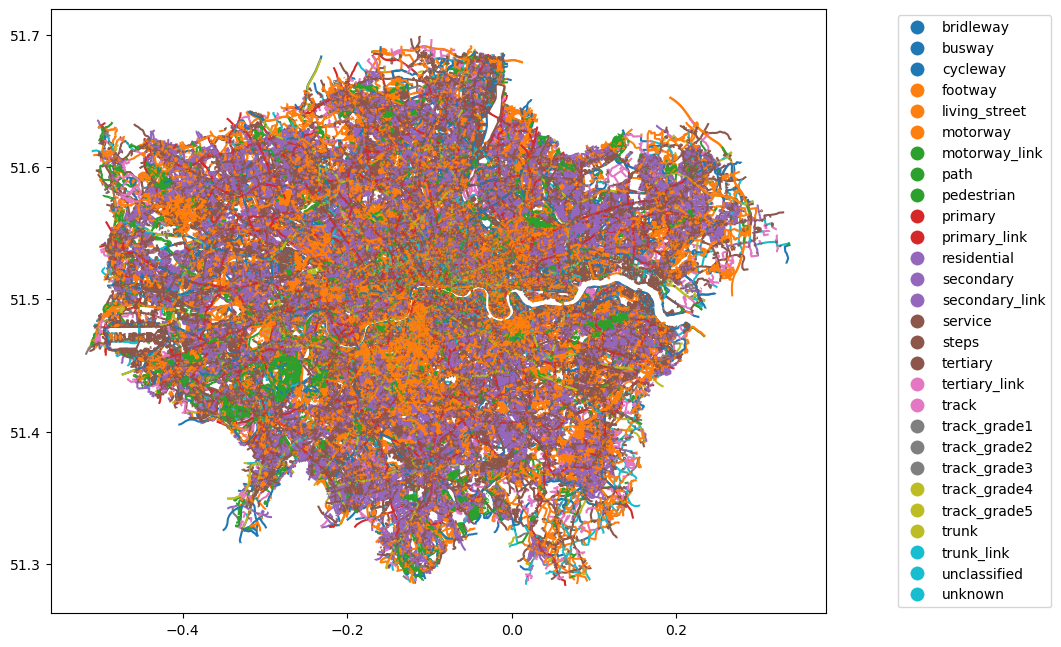

In [47]:
london_roads.plot(figsize=(10,10), column='fclass', legend=True, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})

## London Traffic A

(13957, 5)


C:\Users\kevin\anaconda3\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

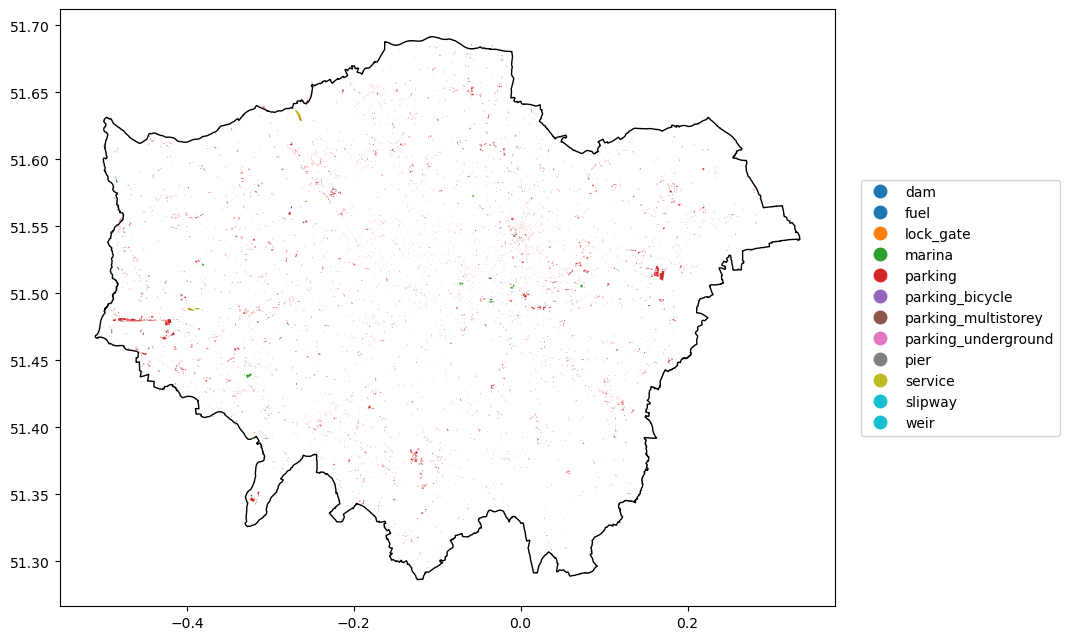

In [44]:
london_traffic_a = gpd.read_file(path.join(folder, "greater-london-latest/gis_osm_traffic_a_free_1.shp"))
print(london_traffic_a.shape)

london_traffic_a.plot(column=data_column, 
                    ax=london_gdf.plot(column=map_column, 
                                       figsize=(10,10), 
                                       color='white', 
                                       edgecolor='black'), 
                    legend=True, markersize=20, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})

## London Traffic

(91510, 5)


C:\Users\kevin\anaconda3\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

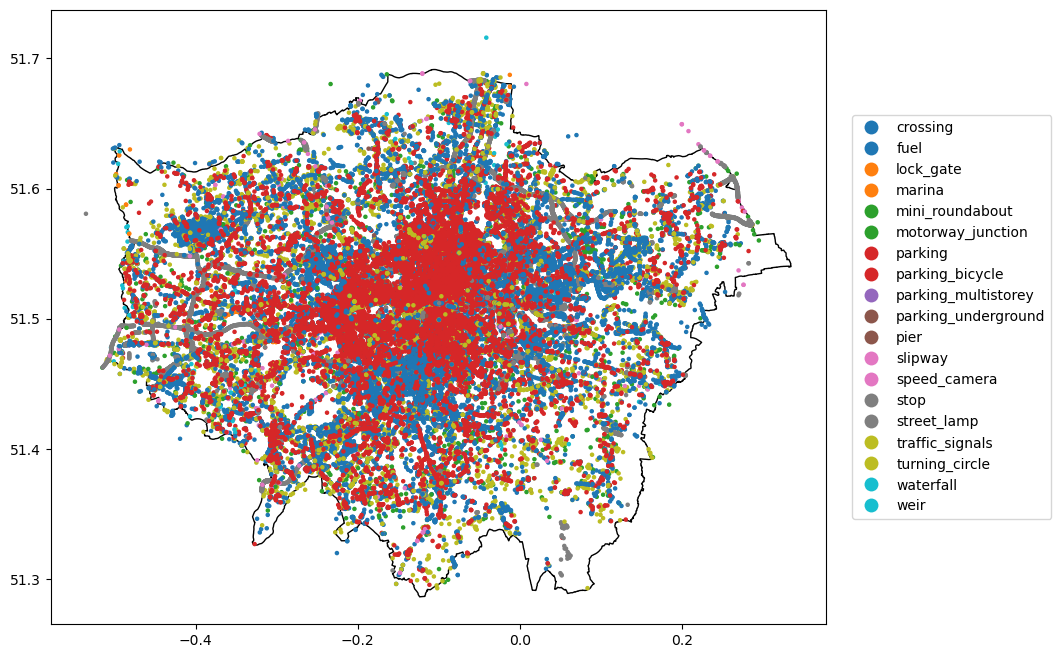

In [43]:
london_traffic = gpd.read_file(path.join(folder, "greater-london-latest/gis_osm_traffic_free_1.shp"))
print(london_traffic.shape)

london_traffic.plot(column=data_column, 
                    ax=london_gdf.plot(column=map_column, 
                                       figsize=(10,10), 
                                       color='white', 
                                       edgecolor='black'), 
                    legend=True, markersize=5, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})

## London Transport

In [59]:
london_transport = gpd.read_file(path.join(folder, "greater-london-latest/gis_osm_transport_free_1.shp"))
print(london_transport.shape)
london_transport

(20946, 5)


,osm_id,code,fclass,name,geometry
0,780856,5601,railway_station,Shepherd's Bush Market,POINT (-0.22631 51.50607)
1,1256794,5601,railway_station,West Drayton,POINT (-0.47183 51.50974)
2,2013971,5601,railway_station,Finchley Central,POINT (-0.19232 51.60084)
3,9780241,5601,railway_station,St Mary Cray,POINT (0.10572 51.39474)
4,13884199,5601,railway_station,Mill Hill Broadway,POINT (-0.24880 51.61267)
...,...,...,...,...,...
20941,10271542619,5621,bus_stop,Hail and Ride Roman Way,POINT (-0.06469 51.64654)
20942,10552747527,5621,bus_stop,Brent Cross Coach Stop,POINT (-0.21987 51.57606)
20943,10559315572,5621,bus_stop,Brooksby's Walk,POINT (-0.04233 51.54896)
20944,10568604717,5621,bus_stop,None,POINT (-0.48008 51.48036)


C:\Users\kevin\anaconda3\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot:>

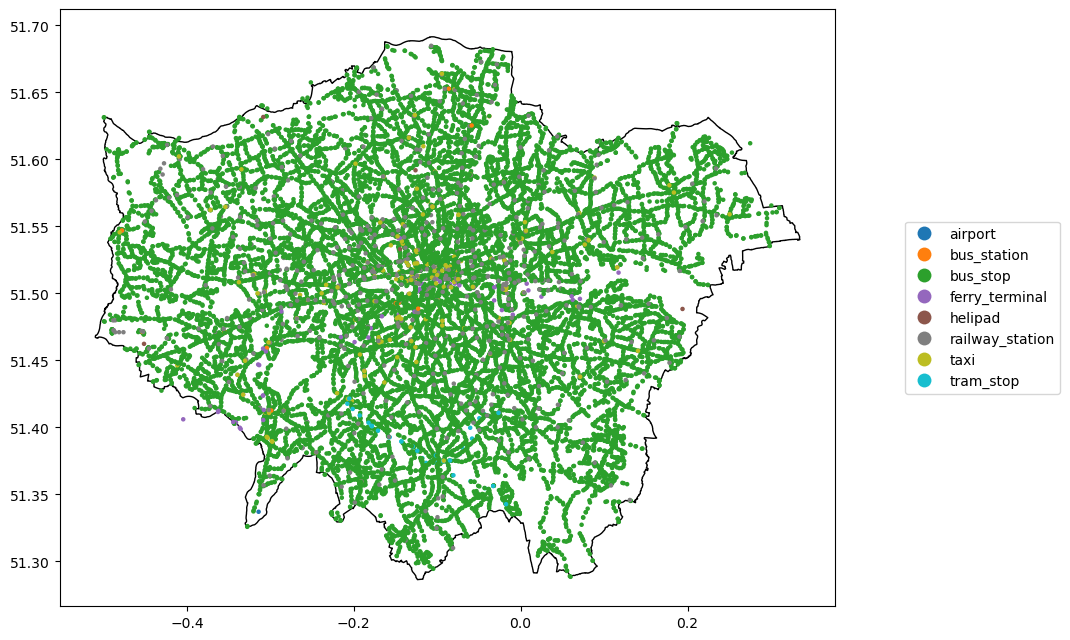

In [60]:
london_transport.plot(column=data_column, 
                      ax=london_gdf.plot(column=map_column, 
                                         figsize=(10,10), 
                                         color='white', 
                                         edgecolor='black'), 
                      legend=True, markersize=5, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})

## London Places

In [74]:
london_places = gpd.read_file(path.join(folder, "greater-london-latest/gis_osm_places_a_free_1.shp"))
print(london_places.shape)
london_places

(57, 6)


,osm_id,code,fclass,population,name,geometry
0,3322449,1020,island,0,Isleworth Ait,"POLYGON ((-0.32130 51.46709, -0.32127 51.46710..."
1,4768550,1020,island,0,None,"POLYGON ((-0.13175 51.59663, -0.13159 51.59667..."
2,4865817,1004,hamlet,0,Bellenden,"POLYGON ((-0.08003 51.46189, -0.07936 51.46264..."
3,4517603,1050,locality,0,Osterley Fields,"POLYGON ((-0.37135 51.48935, -0.36559 51.49037..."
4,9709174,1020,island,0,Glover's Island,"POLYGON ((-0.30638 51.44939, -0.30637 51.44941..."
5,26932726,1020,island,0,Eel Pie Island,"POLYGON ((-0.32813 51.44401, -0.32807 51.44406..."
6,43531168,1020,island,0,Steven's Eyot,"POLYGON ((-0.30632 51.41934, -0.30625 51.41989..."
7,48076585,1020,island,0,Thames Ditton Island,"POLYGON ((-0.33283 51.39560, -0.33281 51.39578..."
8,48076587,1020,island,0,Boyle Farm Island,"POLYGON ((-0.33020 51.39275, -0.33007 51.39287..."
9,48274365,1020,island,0,Raven's Ait,"POLYGON ((-0.31191 51.39802, -0.31190 51.39811..."


<AxesSubplot:>

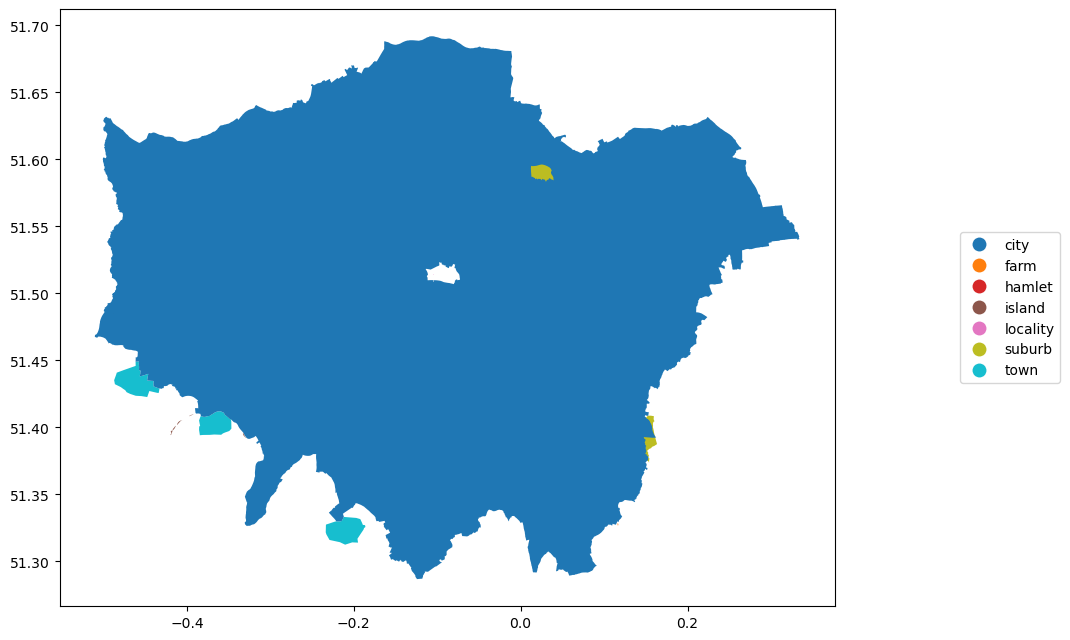

In [75]:
london_places.plot(figsize=(10,10), column='fclass', legend=True, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})

# london_places.plot(column=data_column, 
#                       ax=london_gdf.plot(column=map_column, 
#                                          figsize=(10,10), 
#                                          color='white', 
#                                          edgecolor='black'), 
#                       legend=True, markersize=5, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})

## London Buildings

In [76]:
london_buildings = gpd.read_file(path.join(folder, "greater-london-latest/gis_osm_buildings_a_free_1.shp"))
print(london_buildings.shape)
london_buildings

(804673, 6)


,osm_id,code,fclass,name,type,geometry
0,2956186,1500,building,Laurence House,block,"POLYGON ((-0.02169 51.44459, -0.02168 51.44464..."
1,2956187,1500,building,Lewisham Town Hall,None,"POLYGON ((-0.02181 51.44498, -0.02161 51.44507..."
2,2956188,1500,building,Broadway Theatre,None,"POLYGON ((-0.02067 51.44542, -0.02064 51.44544..."
3,2956192,1500,building,JD Sports,store,"POLYGON ((-0.01900 51.44462, -0.01894 51.44486..."
4,2956193,1500,building,Air Thrill,store,"POLYGON ((-0.01834 51.44500, -0.01815 51.44551..."
...,...,...,...,...,...,...
804668,1139715884,1500,building,None,house,"POLYGON ((-0.13230 51.62405, -0.13227 51.62415..."
804669,1139715885,1500,building,None,house,"POLYGON ((-0.13212 51.62399, -0.13209 51.62408..."
804670,1139715886,1500,building,None,semidetached_house,"POLYGON ((-0.13182 51.62400, -0.13181 51.62403..."
804671,1139715887,1500,building,None,semidetached_house,"POLYGON ((-0.13194 51.62402, -0.13190 51.62412..."


<AxesSubplot:>

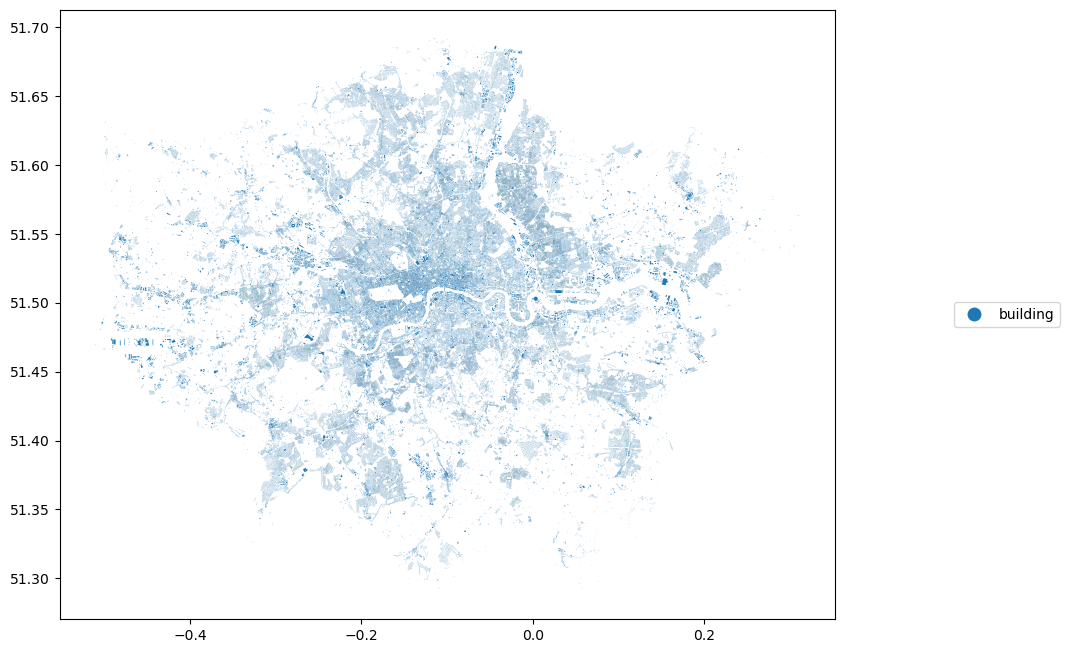

In [77]:
london_buildings.plot(figsize=(10,10), column='fclass', legend=True, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})

# london_places.plot(column=data_column, 
#                       ax=london_gdf.plot(column=map_column, 
#                                          figsize=(10,10), 
#                                          color='white', 
#                                          edgecolor='black'), 
#                       legend=True, markersize=5, legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.3,0.5)})